https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('./data/GlobalLandTemperaturesByMajorCity.csv',parse_dates=['dt'])

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [8]:
df.shape

(239177, 7)

In [15]:
import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
#     fld_dtype = fld.dtypes[0]
    
#     if not np.issubdtype(fld_dtype, np.datetime64):
#         df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'
           ]
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [16]:
add_datepart(df,'dt')
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,dtYear,dtMonth,dtWeek,dtDay,dtDayofweek,dtDayofyear,dtElapsed
0,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,1,1,1,0,1,-3818361600
1,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,2,5,1,3,32,-3815683200
2,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,3,9,1,3,60,-3813264000
3,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,4,13,1,6,91,-3810585600
4,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,5,18,1,1,121,-3807993600


In [115]:
print(len(df.dtYear.unique()))
df = df.loc[:,['AverageTemperature', 'City','Country','dtYear', 'dtMonth', 'dtWeek','dtDay', 'dtDayofweek', 'dtDayofyear', 'dtElapsed']].dropna()
valid_idx =[idx for idx,year,day in zip(range(len(df)),list(df.dtYear),list(df.dtDayofweek)) if (year >2010 or year in [1975,1995,1996,2007,1875,1876,1877] or day == 6)] 
print(len(valid_idx))
print(valid_idx[-100:])
print(df.shape)

267
42480
[227871, 227879, 227888, 227894, 227897, 227911, 227914, 227917, 227925, 227934, 227943, 227951, 227952, 227953, 227954, 227955, 227956, 227957, 227958, 227959, 227960, 227961, 227962, 227963, 227964, 227965, 227966, 227967, 227968, 227969, 227970, 227971, 227972, 227973, 227974, 227980, 227988, 227989, 227997, 228006, 228020, 228026, 228029, 228043, 228046, 228052, 228060, 228066, 228075, 228083, 228092, 228095, 228096, 228097, 228098, 228099, 228100, 228101, 228102, 228103, 228104, 228105, 228106, 228112, 228120, 228121, 228129, 228138, 228143, 228144, 228145, 228146, 228147, 228148, 228149, 228150, 228151, 228152, 228153, 228154, 228155, 228156, 228157, 228158, 228159, 228160, 228161, 228162, 228163, 228164, 228165, 228166, 228167, 228168, 228169, 228170, 228171, 228172, 228173, 228174]
(228175, 10)


In [116]:
from fastai import *
from fastai.tabular import *

In [117]:
print(len(valid_idx),df.shape)
cat_names = ['City','Country']
dep_var = 'AverageTemperature'

42480 (228175, 10)


In [118]:
procs = [FillMissing, Categorify, Normalize]
data = TabularDataBunch.from_df('data', df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

In [119]:
learn = tabular_learner(data,[32,32],metrics=mean_absolute_error,
#                         ,emb_szs={'City':5,'Country':5},
                        callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


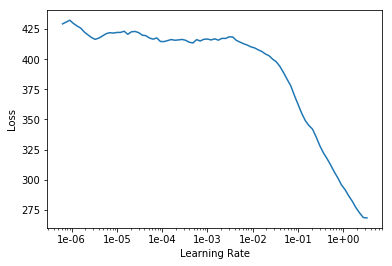

In [120]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,4.494943,1.814337,0.969131,00:21


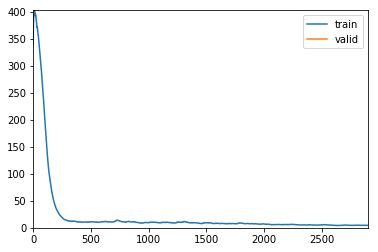

In [121]:
learn.fit_one_cycle(1,1e-1)

In [122]:
learn.validate()

[1.8143369, tensor(0.9691)]

In [123]:
print(df.iloc[1111,:])
learn.predict(df.iloc[1111,:])

AverageTemperature           28.449
City                        Abidjan
Country               Côte D'Ivoire
dtYear                         1958
dtMonth                           3
dtWeek                            9
dtDay                             1
dtDayofweek                       5
dtDayofyear                      60
dtElapsed                -373593600
Name: 1310, dtype: object


(FloatItem [27.449913], tensor([27.4499]), tensor([27.4499]))

TODO interpert where errors are